In [2]:
dfs = ['2023-09-17_21-32-08.csv', '2023-09-21_00-21-39.csv', '2023-09-23_07-30-31.csv', '2023-09-21_12-07-51.csv', '2023-09-21_04-28-09.csv', '2023-09-22_22-45-02.csv', '2023-09-21_16-10-04.csv', '2023-09-22_18-44-09.csv', '2023-10-09_17-45-16.csv', '2023-09-21_22-20-00.csv', '2023-10-02_15-35-23.csv', '2023-09-21_14-57-18.csv', '2023-09-21_18-56-11.csv', '2023-09-20_09-06-07.csv', '2023-09-23_13-02-39.csv', '2023-09-14_09-32-11.csv', '2023-09-15_13-10-22.csv', '2023-09-22_11-50-14.csv', '2023-09-19_22-28-45.csv']
filenames = [
    "debug_2023-09-17_21-32-08.log",
    "debug_2023-09-21_00-21-39.log",
    "debug_2023-09-23_07-30-31.log",
    "debug_2023-09-21_12-07-51.log",
    "debug_2023-09-21_04-28-09.log",
    "debug_2023-09-22_22-45-02.log",
    "debug_2023-09-21_16-10-04.log",
    "debug_2023-09-22_18-44-09.log",
    "debug_2023-10-09_17-45-16.log",
    "debug_2023-09-21_22-20-00.log",
    "debug_2023-10-02_15-35-23.log",
    "debug_2023-09-21_14-57-18.log",
    "debug_2023-09-21_18-56-11.log",
    "debug_2023-09-20_09-06-07.log",
    "debug_2023-09-23_13-02-39.log",
    "debug_2023-09-14_09-32-11.log",
    "debug_2023-09-15_13-10-22.log",
    "debug_2023-09-22_11-50-14.log",
    "debug_2023-09-19_22-28-45.log"
]

In [29]:
# function that gets all notebooks with a given config

def get_df(bitlen, seclvl, mtalg, client_ip, server_ip, min_bandwidth, max_bandwidth, ignore_bandwidth = False):
    names = []
    dicts = process_files_in_directory('../log/', 0, 26, 50)
    for k in dicts:
        # print(f"DEBUG: extracting config from {k}")
        s = ''.join(dicts[k])[50:]
        d = json.loads(s)
        # skip logs before different bit lengths were introduced
        if 'bit_length' not in d['misc']:
            continue
        if d['client']['ip_address'] == client_ip and d['server']['ip_address'] == server_ip:
            if d['misc']['security_level'] == seclvl and d['misc']['mt_algorithm'] == mtalg and d['misc']['bit_length'] == bitlen:
                #print(f"Found file that has appropriate config: {k}")
                bandwidth = extract_bandwidth_from_log_file(f'../log/{k}')
                if ignore_bandwidth:
                    names.append(k[6:-4])
                elif bandwidth:
                    if float(bandwidth) > min_bandwidth and float(bandwidth) < max_bandwidth:
                        names.append(k[6:-4])
    files_to_remove = []
    for file_name in names:
        if not os.path.exists(f'../dfs/{file_name}.csv'):
            # File doesn't exist, add it to the list for removal
            #print(f"df for {file_name} does not exist!")
            files_to_remove.append(file_name)
    
    # Remove the files that don't exist from the original list
    for file_name in files_to_remove:
        names.remove(file_name)
    return pd.concat((pd.read_csv(f"../dfs/{df_name}.csv") for df_name in names), ignore_index=True).reset_index(drop=True)

def read_lines(file_path, start_line, end_line):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines = lines[start_line:end_line]
    return lines
def read_until_info(file_path):
    out = []
    with open(file_path, 'r') as file:
        x = file.readline()
        while not 'INFO'in x:
            out.append(x)
            x = file.readline()
    return out
def process_files_in_directory(directory_path, n, m, k):
    result_dict = {}

    # Iterate over files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        # Check if it's a file (not a directory)
        if os.path.isfile(file_path):
            # Check if the file has more than N rows
            with open(file_path, 'r') as file:
                line_count = sum(1 for _ in file)

            if line_count > k:
                # Read lines n to m from the file
                lines = read_until_info(file_path)

                # Store the lines in a JSON dictionary
                result_dict[filename] = lines

    return result_dict
def remove_chars_after_last_bracket(input_string):
    last_bracket_index = input_string.rfind('}')
    
    if last_bracket_index != -1:
        return input_string[:last_bracket_index + 1]
    else:
        # If there are no closing curly brackets, return the original string
        return input_string
    
def extract_bandwidth_from_log_file(log_file_path):

    # Open the log file and iterate through its lines
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # Use a regular expression to match the "Bandwidth:" string and the float value
            match = re.search(r"andwidth: (\d+\.\d+) Mbits/sec", line)
            if match:
                bandwidth_str = match.group(1)
                return(float(bandwidth_str))

    return None

def remove_results_between(df, column, a, b):
    return df[(df[column].notna()) & (df[column] > a) & (df[column] < b)] 

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
import re
import json
plt.rcParams['figure.figsize'] = [5, 5]  # default hor./vert. size of plots, in inches

In [9]:
import os
def print_file_info(filename):
    filepath = os.path.join("../log", filename)
    print(f"--- File: {filepath} ---")
    with open(filepath, 'r') as file:
        lines = file.readlines()
        total_lines = len(lines)
        print(f"Total number of lines: {total_lines}")
        for i, line in enumerate(lines):
            print(line.rstrip())  # rstrip() to remove newline characters
            if i + 1 >= N:
                break
        print()

N = 30  # Number of lines to print from each file
for filename in filenames:
    print_file_info(filename)

--- File: ../log/debug_2023-09-17_21-32-08.log ---
Total number of lines: 3923
2023-09-17 21:32:08,229 - DEBUG - pffrocd config: {
    "client": {
        "ip_address": "192.168.5.115",
        "username": "kamil",
        "private_ssh_key_path": "/home/dietpi/.ssh/id_rsa",
        "executable_path": "/home/kamil/pffrocd/ABY/build/bin",
        "executable_name": "cos_dist_float_scen_simd",
        "pffrocd_path": "/home/kamil/pffrocd"
    },
    "server": {
        "ip_address": "192.168.5.114",
        "username": "kamil",
        "private_ssh_key_path": "/home/dietpi/.ssh/id_rsa",
        "executable_path": "/home/kamil/pffrocd/ABY/build/bin",
        "executable_name": "cos_dist_float_scen_simd",
        "pffrocd_path": "/home/kamil/pffrocd"
    },
    "misc": {
        "nr_of_people": "1500",
        "security_level": "128",
        "mt_algorithm": "0",
        "niceness": "-20",
        "starting_person": "20",
        "bit_length": "32",
        "gather_energy_data": "1"
    }
}

582
288


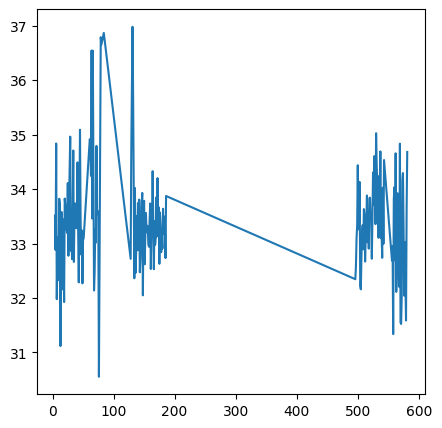

Energy mean: 18.244702445430953


,cos_dist_np,cos_dist_sfe,total_time,sfe_time,extraction_time,server.User time (seconds),server.System time (seconds),server.Average shared text size (kbytes),server.Average unshared data size (kbytes),server.Average stack size (kbytes),...,communication.setup.sent,communication.setup.received,communication.otextension.sent,communication.otextension.received,communication.garbling.sent,communication.garbling.received,communication.online.sent,communication.online.received,cos_dist_ver,cos_dist_sfe.1
count,196.000000,1.960000e+02,196.000000,196.000000,196.000000,196.000000,196.000000,196.0,196.0,196.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.690975,9.998901e+34,57.170348,40.364333,16.806015,15.901122,5.092806,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.241305,1.399846e+36,4.467120,1.582748,3.473783,2.094453,0.644534,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.133294,1.332946e-01,51.257733,36.908136,14.151079,13.960000,3.960000,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.484983,4.849832e-01,54.849361,39.631944,15.005480,14.630000,4.817500,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.751352,7.703599e-01,56.548189,40.245504,16.237687,16.245000,5.035000,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.880205,8.889890e-01,57.863637,40.798200,17.248594,16.450000,5.270000,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1.157249,1.959785e+37,79.844558,50.252171,36.614888,31.220000,9.910000,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


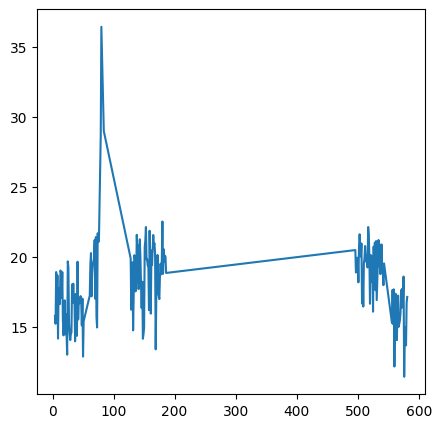

In [39]:
#df_all = pd.concat((pd.read_csv(f"../dfs/{df_name}") for df_name in dfs), ignore_index=True).reset_index(drop=True)
df_112 = get_df('32', '112', '0', "192.168.5.115", "192.168.5.114", 0, 1000, True)
print(len(df_112))
df_112 = df_112[pd.to_numeric(df_112['energy_server'], errors='coerce').notnull()]
print(len(df_112))
# df_all = df_all[pd.to_numeric(df_all['server.hardware.throughput'], errors='coerce').notnull()]
# print(len(df_all))
# (df_all['server.hardware.throughput']*8).plot()
# plt.show()
df_112 = remove_results_between(df_112, 'server.timings.total', 0, 37_000)
(df_112['server.timings.total'] / 1000).plot()
plt.show()
df_112['energy_server'].plot()
print(f"Energy mean: {df_112['energy_server'].mean()}")
df_112.describe()

416
232


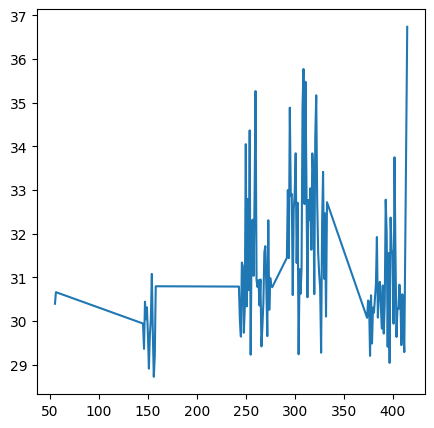

Energy mean: 14.83079622079


,Unnamed: 0,cos_dist_np,cos_dist_sfe,total_time,sfe_time,extraction_time,server.User time (seconds),server.System time (seconds),server.Average shared text size (kbytes),server.Average unshared data size (kbytes),...,communication.setup.sent,communication.setup.received,communication.otextension.sent,communication.otextension.received,communication.garbling.sent,communication.garbling.received,communication.online.sent,communication.online.received,cos_dist_ver,cos_dist_sfe.1
count,133.000000,133.000000,1.330000e+02,133.000000,133.000000,133.000000,133.000000,133.000000,133.0,133.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3.368421,0.691252,-6.372606e+06,54.004162,37.240439,16.763722,13.011729,4.681353,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3.525822,0.274603,7.349249e+07,5.048939,1.935094,4.251296,1.248188,0.508147,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.295043,-8.475567e+08,49.024583,34.599101,14.186656,12.360000,3.760000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,0.404955,4.049551e-01,51.468096,36.053570,14.695362,12.730000,4.400000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,0.682654,6.826544e-01,52.885441,36.677538,15.225100,12.900000,4.600000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.000000,0.952215,9.522154e-01,54.665017,38.283298,16.452303,13.070000,4.870000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,13.000000,1.173064,1.173064e+00,79.212046,48.974856,35.750998,27.050000,8.830000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


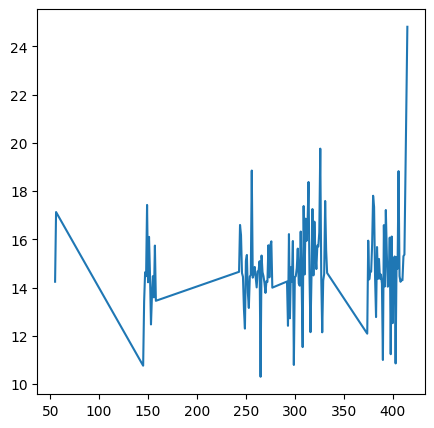

In [40]:
#df_all = pd.concat((pd.read_csv(f"../dfs/{df_name}") for df_name in dfs), ignore_index=True).reset_index(drop=True)
df_80 = get_df('32', '80', '0', "192.168.5.115", "192.168.5.114", 0, 1000, True)
print(len(df_80))
df_80 = df_80[pd.to_numeric(df_80['energy_server'], errors='coerce').notnull()]
print(len(df_80))
# df_all = df_all[pd.to_numeric(df_all['server.hardware.throughput'], errors='coerce').notnull()]
# print(len(df_all))
# (df_all['server.hardware.throughput']*8).plot()
# plt.show()
df_80 = remove_results_between(df_80, 'server.timings.total', 0, 37_000)
(df_80['server.timings.total'] / 1000).plot()
plt.show()
df_80['energy_server'].plot()
print(f"Energy mean: {df_80['energy_server'].mean()}")
df_80.describe()

1029
290


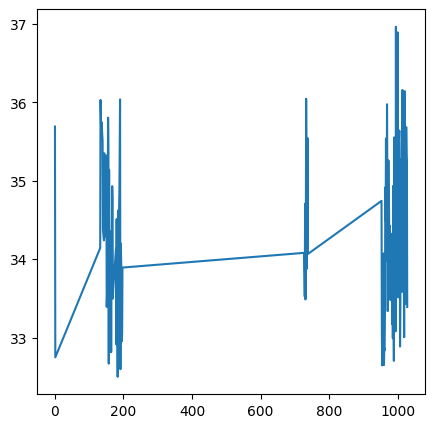

Energy mean: 18.291245378677353


,Unnamed: 0,cos_dist_np,cos_dist_sfe,total_time,sfe_time,extraction_time,server.User time (seconds),server.System time (seconds),server.Average shared text size (kbytes),server.Average unshared data size (kbytes),...,communication.setup.sent,communication.setup.received,communication.otextension.sent,communication.otextension.received,communication.garbling.sent,communication.garbling.received,communication.online.sent,communication.online.received,cos_dist_ver,cos_dist_sfe.1
count,140.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000,140.000000,140.000000,140.0,140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,2.557143,0.688406,7.854882e+12,60.360904,42.124983,18.235921,16.496429,5.031857,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.856953,0.242397,9.294022e+13,6.147518,1.046831,5.800898,0.790340,0.311900,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.171300,1.713002e-01,54.774261,40.134510,14.177163,15.590000,4.350000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,0.482489,4.750053e-01,56.476176,41.393942,14.544598,16.007500,4.797500,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,0.746785,7.467851e-01,57.430528,42.165323,15.057161,16.240000,5.055000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.000000,0.889090,8.942610e-01,64.578608,42.948752,22.560354,16.530000,5.220000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,13.000000,1.110928,1.099683e+15,79.825443,44.530219,35.691926,18.700000,5.820000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


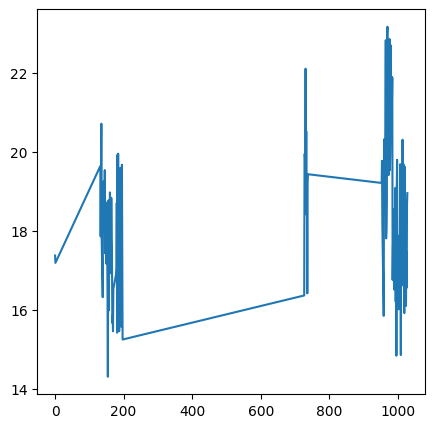

In [41]:
#df_all = pd.concat((pd.read_csv(f"../dfs/{df_name}") for df_name in dfs), ignore_index=True).reset_index(drop=True)
df_128 = get_df('32', '128', '0', "192.168.5.115", "192.168.5.114", 0, 1000, True)
print(len(df_128))
df_128 = df_128[pd.to_numeric(df_128['energy_server'], errors='coerce').notnull()]
print(len(df_128))
# df_all = df_all[pd.to_numeric(df_all['server.hardware.throughput'], errors='coerce').notnull()]
# print(len(df_all))
# (df_all['server.hardware.throughput']*8).plot()
# plt.show()
df_128 = remove_results_between(df_128, 'server.timings.total', 0, 37_000)
(df_128['server.timings.total'] / 1000).plot()
plt.show()
df_128['energy_server'].plot()
print(f"Energy mean: {df_128['energy_server'].mean()}")
df_128.describe()

Time: 31.272209601503757
RAM: 1445.64
Energy: 14.83079622079
Time: 33.416388183673476
RAM: 1526.6204081632654
Energy: 18.244702445430953
Time: 34.31787646428571
RAM: 1591.0891428571426
Energy: 18.291245378677353


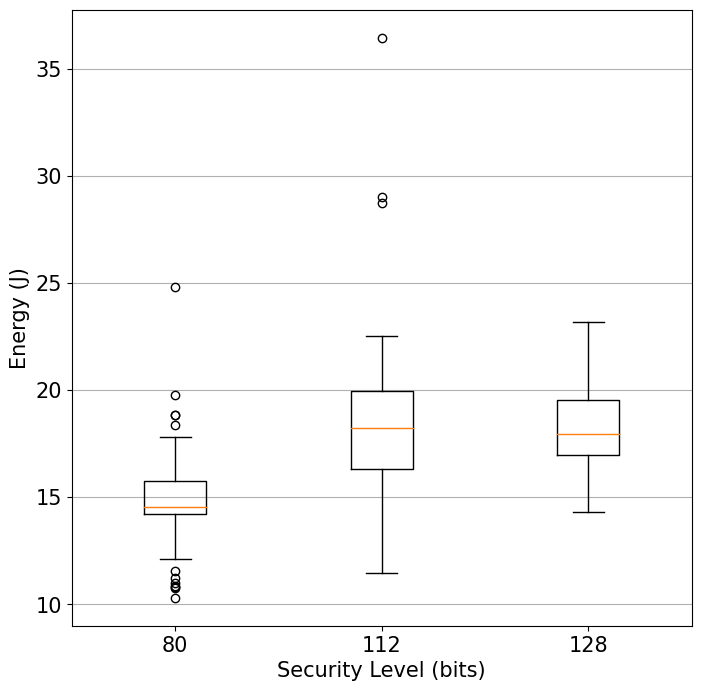

In [44]:
# plotting energy
plt.rcParams.update({'font.size': 15})
df_list = [df_80, df_112, df_128]
plt.rcParams['figure.figsize'] = [8, 8]  # default hor./vert. size of plots, in inches
labels = ['80', '112', '128']
ax = plt.boxplot([df['energy_server'] for df in df_list], labels=labels)
plt.xlabel("Security Level (bits)")
plt.ylabel("Energy (J)")
plt.grid(axis='y')
plt.savefig("ex2_tb1_energy.pdf", format="pdf", bbox_inches="tight")
for d in df_list:
    print (f"Time: {d['server.timings.total'].mean() / 1000}")
    print (f"RAM: {d['server.Maximum resident set size (kbytes)'].mean() / 100}")
    print (f"Energy: {d['energy_server'].mean()}")